# Deep learning in genomics - Basic model with PyTorch and fastai

This notebook is based on the [jupyter notebook](https://nbviewer.jupyter.org/github/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb) from the publication ["A primer on deep learning in genomics"](https://www.nature.com/articles/s41588-018-0295-5) but uses the [fastai](https://www.fast.ai) library based on [PyTorch](https://pytorch.org).

# Notebook setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [16]:
import pdb

In [4]:
# fastai version
__version__

'1.0.39.dev0'

# Data setup

Loading data from the web, generating dthe ataframe, and saving it to disk is carried out in [Basic model with PyTorch jupyter notebook](https://nbviewer.jupyter.org/github/MicPie/genomics/blob/master/DL_Genomics_v8_basic-pytorch.ipynb).

## Data frame setup

In [6]:
seq_df = pd.read_csv('seq_df.csv', index_col=0)

In [7]:
# add column NoTarget which is not(Target)
seq_df['NotTarget'] = seq_df['Target'].apply(lambda x: int(not(bool(x))))

In [9]:
seq_df.head()

,Sequences,Target,NotTarget
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0,1
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0,1
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0,1
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1,0
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1,0


## fastai data object

### Setup custom fastai data object

In [48]:
# open sequence image function
def open_seq_image(seq:str, cls:type=Image)->Image:
    "Return `Image` object created from sequence string `seq`."
    
    int_enc = LabelEncoder() # setup class instance to encode the four different bases to integer values (1D)
    one_hot_enc = OneHotEncoder(categories=[range(4)]) # setup one hot encoder to encode integer encoded classes (1D) to one hot encoded array (4D)
    
    enc = int_enc.fit_transform(list(seq)) # bases (ACGT) to int (0,1,2,3)
    enc = np.array(enc).reshape(-1,1) # reshape to get rank 2 array (from rank 1 array)
    enc = one_hot_enc.fit_transform(enc) # encoded integer encoded bases to sparse matrix (sparse matrix dtype)
    enc = enc.toarray().T.reshape(4,-1,1) # export sparse matrix to np array
    
    # https://stackoverflow.com/questions/22902040/convert-black-and-white-array-into-an-image-in-python
    x = PIL.Image.fromarray(enc.astype('uint8')).convert('CMYK')
    x = pil2tensor(x,np.float32)
    
    pdb.set_trace()
    
    # optional functions not needed
    #x = x.view(4,-1) # remove first dimension
    #x = x.expand(3, 4, 50) # expand to 3 channel image
    
    return cls(x)

In [49]:
# test open sequence image function
open_seq_image('CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC')

TypeError: Cannot handle this data type

In [31]:
class SeqItemList(ImageItemList):
    "Sequence Item List"
    _bunch,_square_show = ImageDataBunch,True
    def __post_init__(self):
        super().__post_init__()
        self.sizes={}
    
    def open(self, seq): return open_seq_image(seq)
    
    def get(self, i):
        seq = self.items[i][0]
        res = self.open(seq)
        return res
    
    @classmethod
    def import_from_df(cls, df:DataFrame, cols:IntsOrStrs=0, **kwargs)->'ItemList':
        "Get the sequences in `col` of `df` and return cls and df."
        return cls(items=df[cols].values, xtra=df)

In [32]:
bs = 64

In [33]:
data = (SeqItemList.import_from_df(seq_df, ['Sequences'])
        .random_split_by_pct(valid_pct=0.25)
        #.split_by_idxs(range(1500), range(1500,2000))
        .label_from_df(['Target', 'NotTarget']) #one_hot=True !
        .databunch(bs=bs))

### Verify data object

#### Check data object

In [34]:
data

ImageDataBunch;

Train: LabelList
y: MultiCategoryList (1500 items)
[MultiCategory NotTarget, MultiCategory NotTarget, MultiCategory NotTarget, MultiCategory Target, MultiCategory Target]...
Path: .
x: SeqItemList (1500 items)
[Image (4, 1, 50), Image (4, 1, 50), Image (4, 1, 50), Image (4, 1, 50), Image (4, 1, 50)]...
Path: .;

Valid: LabelList
y: MultiCategoryList (500 items)
[MultiCategory Target, MultiCategory Target, MultiCategory Target, MultiCategory Target, MultiCategory NotTarget]...
Path: .
x: SeqItemList (500 items)
[Image (4, 1, 50), Image (4, 1, 50), Image (4, 1, 50), Image (4, 1, 50), Image (4, 1, 50)]...
Path: .;

Test: None

In [35]:
# check classes
data.c, data.classes

(2, ['Target', 'NotTarget'])

In [36]:
# check batch size
data.train_dl.batch_size

64

#### Check data points

In [37]:
i = 2
data.x[i]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [38]:
data.y[i]

MultiCategory NotTarget

In [39]:
i = 3
data.x[i]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [39]:
data.y[i]

MultiCategory Target

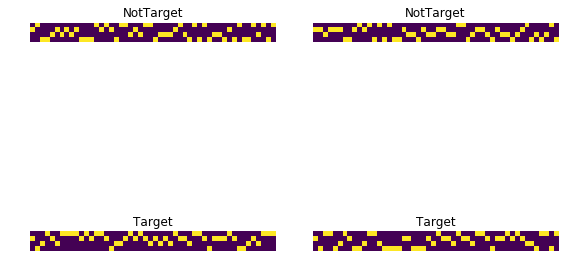

In [40]:
data.show_batch(rows=2)

# Model setup

## Basic model for fastai training

In [41]:
def Flatten(): return Lambda(lambda x: x.view((x.size(0), -1)))

In [42]:
# resize input sequence array from (bs, 1, 4, 50) to (bs, 4, 50) for Conv1d layer
def ResizeInput(): return Lambda(lambda x: x.view((-1,)+x.size()[-2:]))

In [43]:
drop_p = 0.2

In [55]:
net_basic_fastai = nn.Sequential(ResizeInput(),
                    nn.Conv1d(in_channels=4, out_channels=32, kernel_size=12),
                    nn.MaxPool1d(kernel_size=4),
                    Flatten(),
                    nn.Dropout(drop_p),
                    nn.Linear(in_features=288, out_features=16),
                    nn.ReLU(),
                    nn.Dropout(drop_p),
                    nn.Linear(in_features=16, out_features=2),
                    #Debugger()
                   )

In [56]:
net_basic_fastai

Sequential(
  (0): Lambda()
  (1): Conv1d(4, 32, kernel_size=(12,), stride=(1,))
  (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (3): Lambda()
  (4): Dropout(p=0.2)
  (5): Linear(in_features=288, out_features=16, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.2)
  (8): Linear(in_features=16, out_features=2, bias=True)
)

In [57]:
# initialize weights with kaiming normal initialization
apply_init(net_basic_fastai, nn.init.kaiming_normal_)

# Model training

## Train basic model with fastai

In [58]:
learn = Learner(data, net_basic_fastai, loss_func=F.binary_cross_entropy_with_logits, metrics=accuracy_thresh)

In [48]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Lambda               [64, 4, 50]          0          False     
______________________________________________________________________
Conv1d               [64, 32, 39]         1568       True      
______________________________________________________________________
MaxPool1d            [64, 32, 9]          0          False     
______________________________________________________________________
Lambda               [64, 288]            0          False     
______________________________________________________________________
Dropout              [64, 288]            0          False     
______________________________________________________________________
Linear               [64, 16]             4624       True      
______________________________________________________________________
ReLU                 [64, 16]             0          False     
______________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


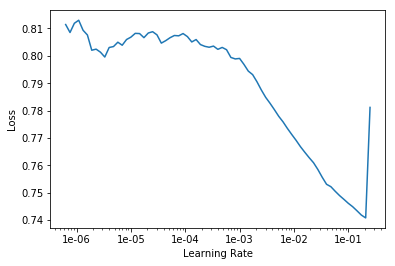

In [49]:
learn.lr_find()
learn.recorder.plot()

In [50]:
learn.fit_one_cycle(10, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy_thresh
1,0.742820,0.689423,0.520000
2,0.702752,0.614599,0.720000
3,0.606981,0.370353,0.823000
4,0.467502,0.177233,0.934000
5,0.344312,0.149260,0.942000
6,0.255275,0.107296,0.956000
7,0.190585,0.071223,0.972000
8,0.136017,0.057507,0.978000
9,0.101842,0.055553,0.982000
10,0.081582,0.054308,0.980000


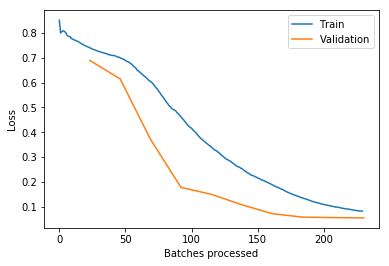

In [53]:
learn.recorder.plot_losses()

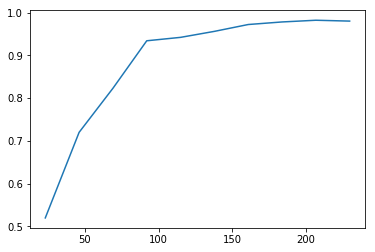

In [54]:
learn.recorder.plot_metrics()

In [59]:
learn.fit(10, lr=1e-2)

epoch,train_loss,valid_loss,accuracy_thresh
1,0.667970,0.518991,0.803000
2,0.508439,0.284481,0.897000
3,0.377611,0.139968,0.950000
4,0.277437,0.092011,0.964000
5,0.201627,0.076286,0.966000
6,0.159187,0.098888,0.958000
7,0.123264,0.055225,0.984000
8,0.094242,0.079985,0.972000
9,0.071857,0.086352,0.960000
10,0.059841,0.086224,0.962000


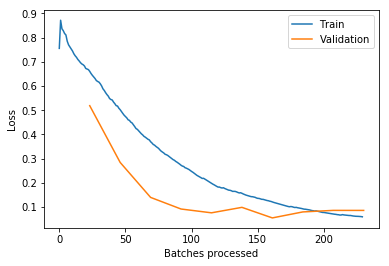

In [60]:
learn.recorder.plot_losses()

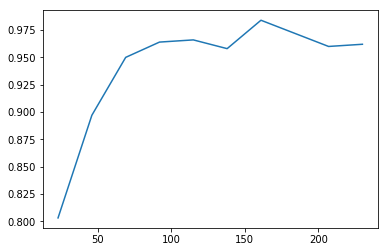

In [61]:
learn.recorder.plot_metrics()

# Interpretation

In [117]:
interpret = learn.interpret()

In [133]:
#interpret.confusion_matrix() # does not work yet!